In [31]:
# ============================================================
# GRU Team Embeddings - Walk-Forward Training
# ============================================================

# ---------------------------
# Imports
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, log_loss

# ---------------------------
# Load and Preprocess Data
# ---------------------------
hist_data = pd.read_csv("final_hist_data.csv")

# Map W/L to 1/0
hist_data['Result'] = hist_data['Result'].map({'W': 1, 'L': 0})

# Ensure Seasonweek is formatted like YYYYWW (e.g., 202401)
hist_data['Seasonweek'] = (
    hist_data['Seasonweek']
    .astype(str)
    .apply(lambda x: x[:4] + x[4:].zfill(2))
    .astype(int)
)

print(hist_data.head())

       Rate  Def Passer Rate  Def Rush Att  Rush Att  TD allowed  Def Cmp%  \
0  0.861510        -1.205811     -1.189206 -0.267598   -1.022158  0.624982   
1 -1.102407         0.906857     -0.267598 -1.189206    1.094890  2.021750   
2  0.166709         2.213375     -0.004281 -0.662573    2.506256  1.281039   
3 -0.435720         0.724183     -1.057548  1.443961    0.389208  0.296953   
4  0.311292        -0.578365     -1.320864 -0.794231   -1.022158 -0.221544   

        3D%  Def Sack Yds        TO    Sk Yds  ...  Yards After Contacts  \
0  3.629110      2.520229  2.349470 -0.879836  ...             -0.368759   
1  0.523400     -0.879836  1.482644  2.520229  ...             -1.147692   
2 -0.979821     -1.266207 -1.117833  0.742923  ...              0.187622   
3 -0.022581      1.438391  0.615818 -1.266207  ...              0.187622   
4 -0.022581     -0.338916 -0.251007 -1.111658  ...             -1.518612   

        IAY  Pressured  Rush Yds     BadTh       YAC  Rush 1st Allowed  \


In [77]:
# ---------------------------
# GRU Model Builder
# ---------------------------
def build_gru_model(input_shape, lr=5e-3):
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [78]:
# ---------------------------
# Prepare Features/Labels
# ---------------------------
teams = hist_data['Team'].unique()
feature_cols = [c for c in hist_data.columns if c not in ['Team', 'Seasonweek', 'Result']]

X_all = hist_data[feature_cols].values.astype(np.float32)
y_all = hist_data['Result'].values.astype(np.float32)
weeks_all = hist_data['Seasonweek'].values.astype(int)
teams_all = hist_data['Team'].values

In [79]:
import warnings

warnings.filterwarnings('ignore')
# ---------------------------
# Walk-Forward Training
# ---------------------------
weeks = sorted(hist_data['Seasonweek'].unique())
embedding_records = []
results = []

for i in range(1, len(weeks)):
    wk = weeks[i]
    prev_wks = weeks[:i]

    train_idx = np.isin(weeks_all, prev_wks)
    test_idx  = (weeks_all == wk)

    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_test, y_test   = X_all[test_idx], y_all[test_idx]

    if len(y_test) == 0:
        continue

    print(f"Training weeks {prev_wks[0]}–{prev_wks[-1]}, Testing week {wk}, "
          f"n_train={len(y_train)}, n_test={len(y_test)}")

    # Reshape for GRU (samples, timesteps=1, features)
    X_train_r = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_r  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = build_gru_model(input_shape=(1, X_train.shape[1]))

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    lr_sched = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)

    history = model.fit(
        X_train_r, y_train,
        validation_split=0.1,
        epochs=200,
        batch_size=min(64, max(8, len(X_train)//4)),
        verbose=0,
        callbacks=[early_stop, lr_sched]
    )

    # Predictions
    y_pred_prob = model.predict(X_test_r, verbose=0).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    ll  = log_loss(y_test, y_pred_prob, labels=[0,1])

    results.append({
        "week": wk,
        "n_games": len(y_test),
        "accuracy": acc,
        "log_loss": ll,
        "epochs_run": len(history.history['loss'])
    })

    # Extract GRU embeddings (hidden output before dense layers)
    get_embedding = Sequential(model.layers[:1])  # take GRU layer
    embeddings = get_embedding.predict(X_test_r, verbose=0)

    for j, team in enumerate(teams_all[test_idx]):
        record = {"team": team, "seasonweek": wk}
        for k, val in enumerate(embeddings[j]):
            record[f"emb_{k}"] = val
        embedding_records.append(record)

Training weeks 202201–202201, Testing week 202202, n_train=32, n_test=32

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Training weeks 202201–202202, Testing week 202203, n_train=64, n_test=32

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 41: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 45: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 49: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 53: ReduceLROnPlateau reducing learning rate to 9.76562478172127

In [80]:
# ---------------------------
# Save Results
# ---------------------------
results_df = pd.DataFrame(results)
print("\nWeekly Results:\n", results_df)

results_df.to_csv("gru_walkforward_metrics.csv", index=False)

embeddings_df = pd.DataFrame(embedding_records)
embeddings_df.to_csv("gru_team_embeddings_by_week.csv", index=False)

# Save final model
model.save("gru_model_final.keras")
print("\n✅ GRU model and embeddings saved.")


Weekly Results:
       week  n_games  accuracy  log_loss  epochs_run
0   202202       32  0.781250  1.087072          27
1   202203       32  0.812500  0.960228          93
2   202204       32  0.687500  0.629216          18
3   202205       32  0.812500  0.333747          13
4   202206       28  0.821429  0.346184          16
5   202207       28  1.000000  0.055903          24
6   202208       30  0.866667  0.349544          15
7   202209       26  0.884615  0.223444          26
8   202210       28  0.928571  0.244981          22
9   202211       28  0.750000  0.378884          11
10  202212       32  0.781250  0.424684          12
11  202213       30  0.800000  0.500697          21
12  202214       26  0.846154  0.334632          11
13  202215       32  0.812500  0.398981          13
14  202216       32  0.906250  0.258312          13
15  202217       30  0.966667  0.092769          12
16  202218       32  0.781250  0.551736          12
17  202301       32  0.843750  0.340791       

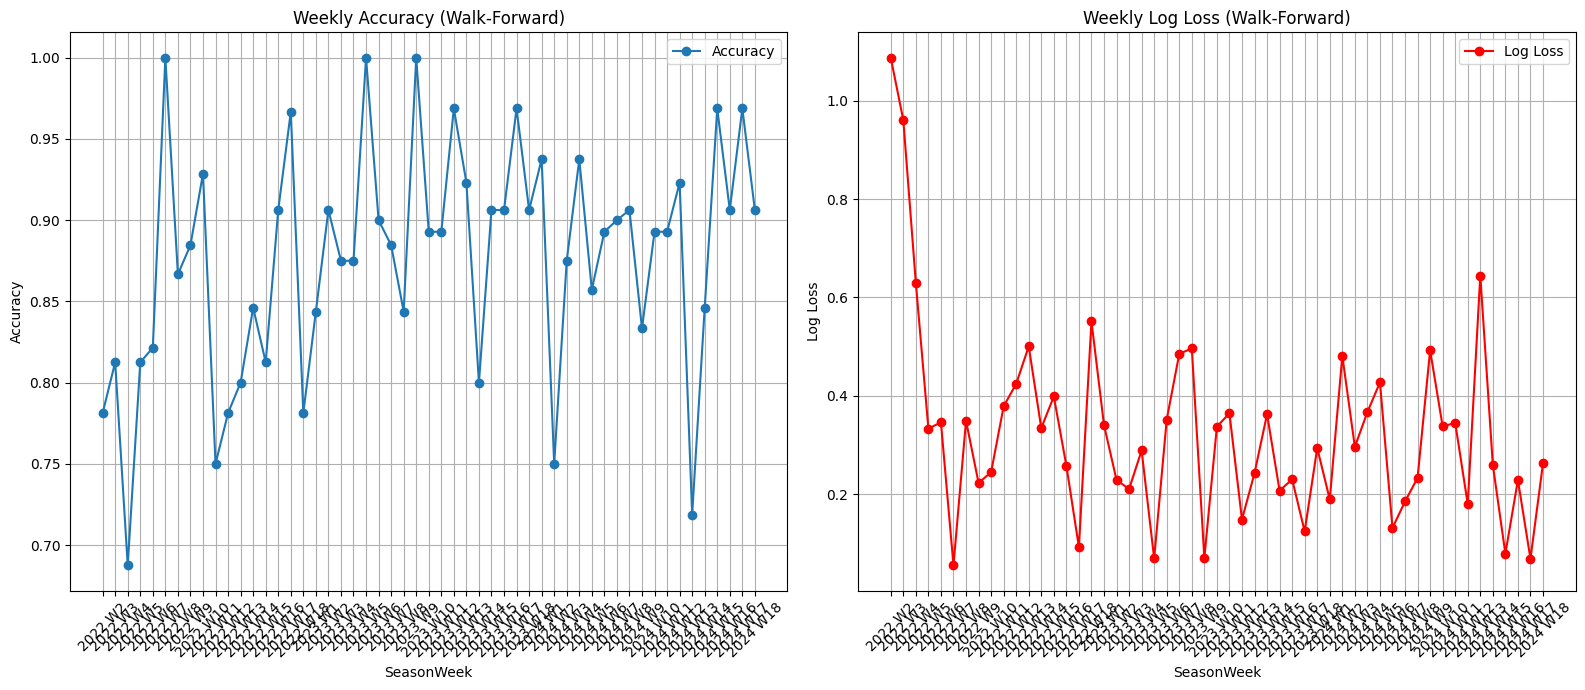

In [81]:
# ---------------------------
# Visualization of Walk-Forward Results
# ---------------------------

# Split Seasonweek into Season and Week
results_df['Season'] = results_df['week'] // 100
results_df['Week'] = results_df['week'] % 100

# Create a combined label: "2024 W1", "2024 W2", ...
results_df['SeasonWeek'] = results_df['Season'].astype(str) + " W" + results_df['Week'].astype(str)

plt.figure(figsize=(16, 7))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(results_df['SeasonWeek'], results_df['accuracy'], marker='o', label="Accuracy")
plt.xlabel("SeasonWeek")
plt.ylabel("Accuracy")
plt.title("Weekly Accuracy (Walk-Forward)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Log Loss Plot
plt.subplot(1, 2, 2)
plt.plot(results_df['SeasonWeek'], results_df['log_loss'], marker='o', color='red', label="Log Loss")
plt.xlabel("SeasonWeek")
plt.ylabel("Log Loss")
plt.title("Weekly Log Loss (Walk-Forward)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
